In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
cur_data = np.loadtxt('data/xyz_tri.csv', delimiter=',')
# cur_data = cur_data[np.where(cur_data[:,0]==380)[0][0]:np.where(cur_data[:,0]==780)[0][0]+1,:]
wave_length = cur_data[:,0]
sep = wave_length[1] - wave_length[0]
    
x,y,z = cur_data[:,1],cur_data[:,2],cur_data[:,3]

print(wave_length[:10],sep)

[360. 361. 362. 363. 364. 365. 366. 367. 368. 369.] 1.0


In [3]:
def calXYZ(phi,xyz,sep):
    length = cur_data.shape[0] * sep
    X = np.sum(phi * cur_data[:,0] * sep)/length
    Y = np.sum(phi * cur_data[:,1] * sep)/length
    Z = np.sum(phi * cur_data[:,2] * sep)/length
    k = 1/Y
    X *= k
    Y *= k
    Z *= k
    return X,Y,Z
    

In [4]:
matrix_RGB_to_XYZ = np.array(
    [
        [0.4185, -0.1587, -0.0828],
        [-0.0912, 0.2524, 0.0157],
        [0.0009, -0.0025, 0.1786],
    ])


# XYZ2SRGB = np.array(
#     [
#         [3.2404542,-1.5371385,-0.4985314],
#         [-0.9692660,1.8760108,0.0415560,],
#         [0.0556434,-2.040259,1.0572252]
#     ]
#     )


XYZ2SRGB = np.array(
    [
        [3.2406, -1.5372, -0.4986],
        [-0.9689, 1.8758, 0.0415],
        [0.0557, -0.2040, 1.0570],
    ]
    )


XYZ2RGB = np.array(
    [
        [2.36461385,-0.89654057,-0.46807328],
        [-0.51516621,1.4264081,0.0887581,],
        [0.0052037,-0.01440816,1.00920446]
    ]
    )
D50XYZ2SRGB = np.array(
    [
        [3.1338561,-1.6168667, -0.4906146],
        [-0.9787684,1.9161415,0.0334540],
        [0.0719453, -0.2289914,  1.4052427]
    ]
    ) 
CAT_CAT02 = np.array(
    [
        [0.7328, 0.4296, -0.1624],
        [-0.7036, 1.6975, 0.0061],
        [0.0030, 0.0136, 0.9834],
    ]
)
 

(471, 2)
(471, 3)
(472, 2)
(256, 256, 3)


array([[ 1.00000000e+00, -2.92533759e-17, -2.04249342e-17],
       [-3.68559861e-17,  1.00000000e+00,  1.32765014e-17],
       [-1.19253266e-18, -6.80522027e-19,  1.00000000e+00]])

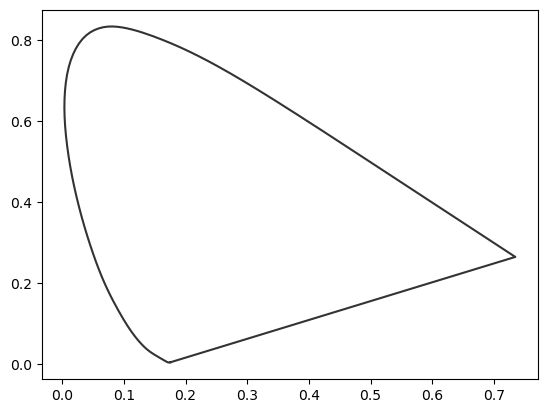

In [5]:
points = np.zeros((cur_data.shape[0],2))
print(points.shape)
# for idx in range(10):# cur_data.shape[0]
#     phi = np.zeros_like(cur_data[:,0])
#     phi[idx] = 1
#     X,Y,Z = calXYZ(phi,cur_data[:,1:],sep)
#     print(X,Y,Z)
#     XYZ = np.array([[X],[Y],[Z]])
#     print(XYZ2SRGB@XYZ)
xyz = np.sum(cur_data[:,1:],axis=1)

new = cur_data[:,1:]/ xyz[:,np.newaxis] # x = X/X+Y+Z
print(new.shape)
new_1 = np.concatenate([new[:,:2],new[0,:2][np.newaxis,:]],axis=0)
print(new_1.shape)
plt.plot(new_1[:,0],new_1[:,1],color='#333333')
XYZ = cur_data[:,1:]

samples = 256
ii, jj = np.meshgrid(
            np.linspace(0, 1, samples), np.linspace(1, 0, samples)
        )
ij = np.concatenate((ii[...,np.newaxis],jj[...,np.newaxis]),axis=-1)
xyY = np.concatenate((ij,np.ones_like(ii)[...,np.newaxis]),axis=-1)
print(xyY.shape)
# np.savetxt(r'aaa.txt',xyY.flatten(),'%.4f')
# plt.show()
xyY.shape
x,y,Y = xyY[...,0],xyY[...,1],xyY[...,2]
XYZ_cg = np.zeros_like(xyY)
m_XYZ = ~(y == 0)
Y_y = Y[m_XYZ] / y[m_XYZ]
XYZ_cg[m_XYZ] = np.vstack(
        [x[m_XYZ] * Y_y, Y[m_XYZ], (1 - x[m_XYZ] - y[m_XYZ]) * Y_y]
    ).T
row,col,dim = XYZ_cg.shape
# XYZ_cg = XYZ_cg.transpose((2,0,1)).reshape(3,-1)
XYZ_cg.shape
np.savetxt(r'aaa.txt',XYZ_cg.flatten(),'%.4f')
# illuminant_XYZ = np.array([0.34570, 0.35850])
illuminant_RGB = np.array([0.31270, 0.32900])
# illuminant_2_XYZ = np.array([illuminant_XYZ[0]/illuminant_XYZ[1],
#                              1,(1-illuminant_XYZ[0]-illuminant_XYZ[1])/illuminant_XYZ[1]])
illuminant_2_RGB = np.array([illuminant_RGB[0]/illuminant_RGB[1],
                             1,(1-illuminant_RGB[0]-illuminant_RGB[1])/illuminant_RGB[1]])

M_CAT = np.linalg.inv(CAT_CAT02)@np.eye(3)
M_CAT@CAT_CAT02

In [15]:


def set_limits(data,limits_from_wavelength,sep =1):
    
    data_limits = np.zeros((401, data.shape[-1] - 1))
    satified_idx = np.logical_and(
        data[:,0] - limits_from_wavelength[0] >= -1e-5,
        limits_from_wavelength[1] - data[:,0] >= -1e-5)
    tmp_data = np.copy(data[satified_idx, :])
    min_val,max_val = data[0,0],data[-1,0]
    if (limits_from_wavelength[0] < min_val) or limits_from_wavelength[1] > max_val:
        new_limits = limits_from_wavelength.astype(float)
        new_limits[1] =  new_limits[1] + sep
        clip_range_data = np.arange(*new_limits,sep)[...,np.newaxis]
        clip_range_data = np.concatenate(
            (clip_range_data, np.zeros_like(clip_range_data)),axis = 1)
        begin_idx = np.argwhere(tmp_data[0,0] == clip_range_data)[0,0]
        end_idx = np.argwhere(tmp_data[-1,0] == clip_range_data)[0,0] + 1
        clip_range_data[begin_idx:end_idx,:] = tmp_data
    else:
        clip_range_data = tmp_data
    return clip_range_data

(401, 2) (401, 4)
[[10043.16831117 10567.0546224  11503.40523081]]
[[0.31273851 0.32905203]]


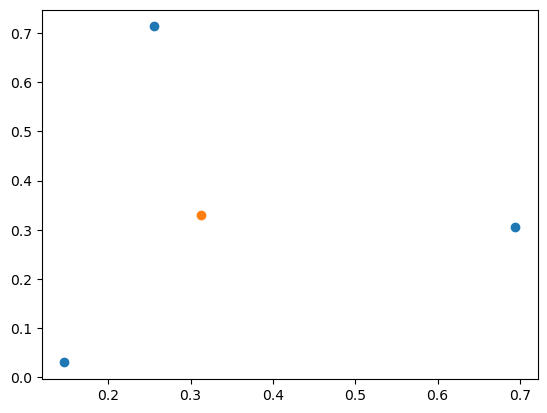

In [33]:
data = np.loadtxt('data\psu_llab\CQS-1-NM.csv',delimiter=',')
limits = np.array([380,780])
data_limits = set_limits(data,limits)
xyz_limits = set_limits(cur_data,limits)

XYZ_data = data_limits[:,1:].T@xyz_limits[:,1:]
idx_sum = XYZ_data.sum(axis=1)
xy = np.zeros((3,2))
for idx in range(3):
    
    xy[idx,:] = [XYZ_data[idx,:2]]/idx_sum[idx]
xy
plt.scatter(xy[:,0],xy[:,1])
data = np.loadtxt('data\CIE_illum_single\CIE_std_illum_D65.csv',delimiter=',')
limits = np.array([380,780])
data_limits = set_limits(data,limits)
xyz_limits = set_limits(cur_data,limits)
print(data_limits.shape,xyz_limits.shape)
# data_limits = np.ones_like(data_limits) # std E
XYZ_data = data_limits[:,1:].T@xyz_limits[:,1:]
print(XYZ_data)
idx_sum = XYZ_data.sum(axis=1)
xy = np.zeros((1,2))
for idx in range(1):
    
    xy[idx,:] = [XYZ_data[idx,:2]]/idx_sum[idx]
print(xy)
plt.scatter(xy[:,0],xy[:,1])

In [8]:
def spow(data,exp):
    data_p = np.sign(data) * np.abs(data) ** exp
    data_p[np.isnan(data_p)] = 0
    return data_p

In [9]:
a = np.loadtxt(r'C:\Users\zqliu\Desktop\colour\aaa.txt')
b = np.loadtxt(r'aaa.txt')
print(np.argwhere(np.abs(a-b)>1e-4).shape,a.shape,(np.argwhere(a!=b).shape[0])/a.shape[0])
np.savetxt('bbb.txt',(a-b).flatten(),fmt='%.4f')


ValueError: operands could not be broadcast together with shapes (1203,) (196608,) 

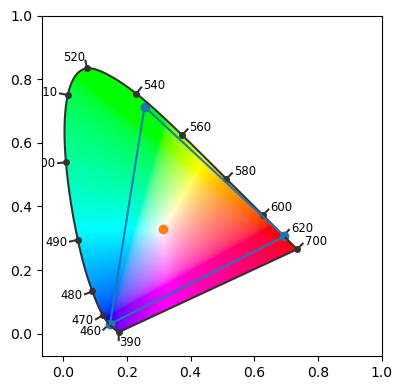

In [10]:
# RGB_cg = np.zeros_like(XYZ_cg)
# for idx_row in range(row):
#     for idx_col in range(col):
#         RGB_cg[idx_row,idx_col,:] = XYZ2SRGB@XYZ_cg[idx_row,idx_col,:] 

RGB_cg = np.einsum("...ij,...j->...i", XYZ2SRGB, XYZ_cg)

RGB_cg = np.where(RGB_cg>0.0031308,1.055*spow(RGB_cg,(1/2.4))-0.055,12.92*RGB_cg)

# np.savetxt('aaa.txt',RGB_cg.flatten(),fmt='%.4f')
# RGB_cg= (RGB_cg/RGB_cg.max())
# RGB_cg = np.clip(RGB_cg,0,1)
with np.errstate(divide="ignore", invalid="ignore"):
    c = np.nan_to_num(1 / RGB_cg.max(axis = -1)[..., None], nan=0, posinf=0, neginf=0)
factor = 1
RGB_cg = RGB_cg * c * factor
RGB_cg = np.clip(RGB_cg,0,factor)
np.savetxt('aaa.txt',RGB_cg.flatten(),fmt='%.4f')

# np.savetxt('aaa.txt',RGB_cg.flatten(),'%.4f')

# fig, axes = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
fig, axes = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
polygon = patches.Polygon(
    new[:,:2],
    facecolor="none",
    edgecolor="none",
    zorder=-140
)
axes.add_patch(polygon)
# print(RGB_cg)
# RGB_cg = RGB_cg.reshape(3,row,col).transpose((1,2,0))
image = axes.imshow(
            RGB_cg,
            interpolation="bicubic",
            extent=(0, 1, 0, 1),
            clip_path=None,
            alpha=1,
            zorder=-140,
        )
image.set_clip_path(polygon)
plt.plot(new_1[:,0],new_1[:,1],color='#333333')


labels = np.array([390, 460, 470, 480, 490, 500, 510,
                   520, 540, 560, 580, 600, 620, 700])

for label in labels:
    data_dict = dict(zip(wave_length,new_1))
    ij_l = data_dict.get(label)
    index = np.argwhere(wave_length==label)[0,0]
    left = wave_length[index - 1] if index >= 0 else wave_length[index]
    right = (
            wave_length[index] if index < len(wave_length) else wave_length[-1]
            )
    dx = data_dict[right][0] - data_dict[left][0]
    dy = data_dict[right][1] - data_dict[left][1]
    direction = np.array([-dy, dx])
    normalized_d = direction/np.linalg.norm(direction)
    tmp_ij_l = ij_l - [1/3,1/3]
    tmp_ij_l = tmp_ij_l/np.linalg.norm(tmp_ij_l)
    true_d = np.array([-dy, dx]) \
            if np.dot(normalized_d,tmp_ij_l) > 0 \
            else np.array([dy, -dx])
    true_d = (true_d/np.linalg.norm(true_d)) / 30
    i , j = ij_l
    axes.plot(
            (i, i + true_d[0] * 0.75),
            (j, j + true_d[1] * 0.75),
            color='#333333', alpha=1, zorder= -120,
        )
    axes.plot(
            i, j, "o", color='#333333',markersize=4,
            alpha=1, zorder= -120,)
    axes.text(
            i + true_d[0], j + true_d[1],
            label, clip_on=True,
            ha="left" if true_d[0] >= 0 else "right",
            va="center", fontdict={"size": "small"},
            zorder=-100,
        )
# plt.xlim([-0.1,0.9]),plt.ylim([-0.1,0.9])
plt.scatter(xy[:,0],xy[:,1])
new_xy = np.vstack((xy,xy[0,:][None,:]))

axes.plot(new_xy[..., 0], new_xy[..., 1])
plt.scatter(0.31270, 0.32900) # D56
plt.show()

[[ 9.66214761e-01 -4.04483264e-02  2.46894927e-02]
 [-2.86804959e-02  1.01863310e+00  1.00474000e-02]
 [ 7.66425404e-04  1.07483548e-03  1.08721649e+00]]
2.358170280197304


<BarContainer object of 401 artists>

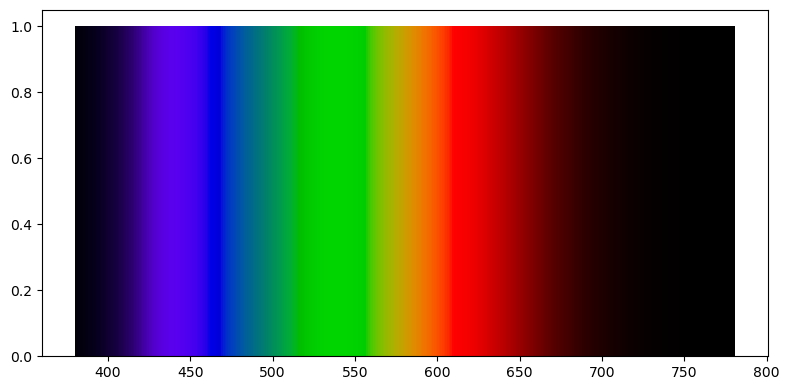

In [11]:

E_white = np.array([1/3,1/3]) # illuminant_XYZ = np.array([0.34570, 0.35850]) STD E

illuminant_RGB = np.array([0.31270, 0.32900])
illuminant_2_E = np.array([E_white[0]/E_white[1],
                             1,(1-E_white[0]-E_white[1])/E_white[1]])
illuminant_2_RGB = np.array([illuminant_RGB[0]/illuminant_RGB[1],
                             1,(1-illuminant_RGB[0]-illuminant_RGB[1])/illuminant_RGB[1]])

RGB_w = CAT_CAT02 @ illuminant_2_E[:,np.newaxis,]
RGB_wr = CAT_CAT02 @ illuminant_2_RGB[:,np.newaxis,]
with np.errstate(divide="ignore", invalid="ignore"):
    D = np.nan_to_num(RGB_wr/ RGB_w, nan=0, posinf=0, neginf=0)
D = np.diag(D.flatten())
M_CAT = np.linalg.inv(CAT_CAT02)@ D @ CAT_CAT02
print(M_CAT)

XYZ_change = XYZ@M_CAT.T
RGB = XYZ_change@XYZ2SRGB.T
# XYZ_change = np.einsum("...ij,...j->...i", M_CAT, XYZ)

# print(XYZ.shape)
# RGB = np.einsum("...ij,...j->...i", XYZ2SRGB, XYZ_change)
# RGB[RGB<0] = 0
print(RGB[20:421].max())
c = 1 / RGB.max(axis = None)
factor = 1
RGB = RGB * c * factor
RGB = np.clip(RGB,0,factor)
RGB = np.where(RGB>0.0031308,1.055*spow(RGB,(1/2.4))-0.055,12.92*RGB)


np.savetxt('aaa.txt',RGB[20:421,:].flatten(),"%.4f")
fig, axes = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
padding = 0.1
axes.bar(
            x= wave_length[20:421]- padding,
            height=1,
            width= sep + padding,
            color=RGB[20:421,:],
            align="edge",
            zorder=-140
        )